In [1]:
import sys
sys.path.append('..')
from src.func import iteratee
from src.architecture import DiabetesClassifier

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data 

In [3]:
df = pd.read_csv("../data/raw/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.drop(columns="Insulin", inplace=True)

# Dataset Splitting 

In [5]:
X = df.drop(columns="Outcome")
y = df['Outcome'].values # .values digunakan karena Series/DataFrame pandas tidak bisa dikonversi ke Tensor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# Preprocess Data 

In [6]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,27.2,0.580,24
711,5,126,78,27,29.6,0.439,40
373,2,105,58,40,34.9,0.225,25
46,1,146,56,0,29.7,0.564,29
682,0,95,64,39,44.6,0.366,22


In [7]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('numeric', numerical_pipeline, X_train.columns)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

# Dataset

In [9]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [10]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

# Training Preparation

In [11]:
X_train.shape

torch.Size([614, 7])

In [12]:
model = DiabetesClassifier(7,16,8,4,2,dropout=0.2).to(device)
criterion = nn.NLLLoss()
#Semisal tidak menggunakan nn.LogSoftMax(), maka criterionnya menggunakan nn.CrossEntropyLoss
optimizer = optim.AdamW(model.parameters(), lr=0.003)
model

DiabetesClassifier(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=8, out_features=4, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=4, out_features=2, bias=True)
      (1): LogSoftmax()
    )
  )
)

# Training Loop 

In [13]:
epochs = 1000

train_cost, test_cost = [], []
train_accuracy, test_accuracy = [], []

for i in range(epochs):
    cost, accuracy = iteratee("train", train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_accuracy.append(accuracy)
    
    with torch.no_grad():
        cost, accuracy = iteratee("test", test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_accuracy.append(accuracy)

    print(f"\rEpoch: {i+1:4}/{epochs:4} | "
          f"train_cost: {train_cost[-1]:.4f} | test_cost: {train_cost[-1]:.4f} | "
          f"train_accuracy: {train_accuracy[-1]:.4f} | test_accuracy: {test_accuracy[-1]:.4f}", end=" ")

Epoch: 1000/1000 | train_cost: 0.4398 | test_cost: 0.4398 | train_accuracy: 0.8046 | test_accuracy: 0.6948 

# Cost History 

In [14]:
import matplotlib.pyplot as plt

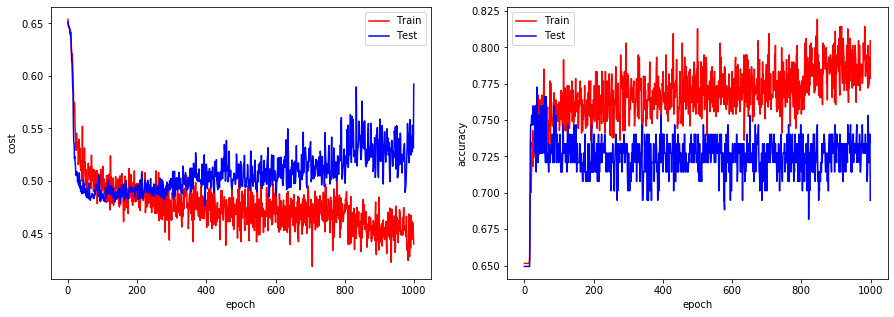

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend();
plt.subplot(122)
plt.plot(train_accuracy, 'r-', label="Train")
plt.plot(test_accuracy, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend();

# Predict

In [16]:
X_test.shape

torch.Size([154, 7])

In [17]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [18]:
torch.exp(output)

tensor([[2.5140e-01, 7.4860e-01],
        [6.9824e-01, 3.0176e-01],
        [4.7385e-01, 5.2615e-01],
        [4.9344e-01, 5.0656e-01],
        [9.9789e-01, 2.1145e-03],
        [5.5973e-01, 4.4027e-01],
        [4.4634e-01, 5.5366e-01],
        [9.8016e-02, 9.0198e-01],
        [9.0851e-01, 9.1495e-02],
        [1.1119e-02, 9.8888e-01],
        [4.0655e-01, 5.9345e-01],
        [1.4156e-03, 9.9858e-01],
        [9.2089e-01, 7.9113e-02],
        [9.1489e-01, 8.5115e-02],
        [7.3300e-01, 2.6700e-01],
        [4.5473e-01, 5.4527e-01],
        [7.3300e-01, 2.6700e-01],
        [9.2398e-01, 7.6016e-02],
        [1.4365e-01, 8.5635e-01],
        [5.1881e-01, 4.8119e-01],
        [7.3300e-01, 2.6700e-01],
        [2.3718e-01, 7.6282e-01],
        [8.2202e-01, 1.7798e-01],
        [1.7822e-01, 8.2178e-01],
        [7.1800e-01, 2.8200e-01],
        [9.2103e-01, 7.8972e-02],
        [3.4833e-01, 6.5167e-01],
        [9.3668e-01, 6.3316e-02],
        [7.5736e-01, 2.4264e-01],
        [9.737

In [19]:
output

tensor([[-1.3807e+00, -2.8955e-01],
        [-3.5919e-01, -1.1981e+00],
        [-7.4685e-01, -6.4218e-01],
        [-7.0635e-01, -6.8012e-01],
        [-2.1167e-03, -6.1589e+00],
        [-5.8031e-01, -8.2036e-01],
        [-8.0667e-01, -5.9121e-01],
        [-2.3226e+00, -1.0316e-01],
        [-9.5955e-02, -2.3915e+00],
        [-4.4991e+00, -1.1181e-02],
        [-9.0006e-01, -5.2180e-01],
        [-6.5602e+00, -1.4166e-03],
        [-8.2418e-02, -2.5369e+00],
        [-8.8957e-02, -2.4638e+00],
        [-3.1061e-01, -1.3205e+00],
        [-7.8805e-01, -6.0648e-01],
        [-3.1061e-01, -1.3205e+00],
        [-7.9060e-02, -2.5768e+00],
        [-1.9403e+00, -1.5508e-01],
        [-6.5621e-01, -7.3150e-01],
        [-3.1061e-01, -1.3205e+00],
        [-1.4389e+00, -2.7074e-01],
        [-1.9599e-01, -1.7261e+00],
        [-1.7247e+00, -1.9628e-01],
        [-3.3128e-01, -1.2659e+00],
        [-8.2265e-02, -2.5387e+00],
        [-1.0546e+00, -4.2822e-01],
        [-6.5409e-02, -2.759

In [20]:
pred = output.argmax(1)
pred

tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

# Accuracy 

In [21]:
accuracy = (y_test == pred).to(torch.float32).mean().item()
accuracy

0.6948052048683167

# Save Model and Weight 

In [22]:
model.state_dict()

OrderedDict([('fc.0.0.weight',
              tensor([[-1.8135,  0.4516, -0.5251,  0.2819,  0.2978,  0.3603, -0.7864],
                      [-0.5458,  0.5265,  0.1959, -0.1876,  0.2073, -0.2463,  0.0902],
                      [ 0.1117, -0.1054, -0.0422,  0.2305, -0.2776, -0.0731, -0.0479],
                      [ 0.2211,  0.6501, -0.1281, -0.2845,  0.2685, -0.0203, -0.2268],
                      [-0.3979, -0.3950,  0.2629, -0.0615, -0.2587, -0.3146, -1.2804],
                      [ 0.4336, -0.3474, -0.0636, -0.8510, -0.5866, -0.0610,  0.5027],
                      [-0.2797, -0.3038, -0.0506, -0.2300,  0.0714, -0.3271, -0.0721],
                      [ 0.0215,  0.4809,  0.2743, -0.2089,  0.1826,  0.2187, -0.1610],
                      [-0.2386, -0.0073, -0.1537,  0.1380,  0.0708, -0.2519,  0.1277],
                      [-0.4787, -0.4050,  0.2538, -0.2973, -0.5578, -0.0997, -0.4490],
                      [ 0.4436,  0.5909, -0.2217,  0.1942,  0.2307,  0.1587,  0.0236],
            

In [23]:
torch.save(model.state_dict(), "../models/weights.pth")

In [24]:
log = {
    "train_cost": train_cost,
    "test_cost": test_cost,
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy
}
torch.save(log, "../models/logs.pth")

# Load Model

In [25]:
model = DiabetesClassifier(7,16,8,4,2,dropout=0.2).to(device)

In [26]:
model.state_dict() # ini jelas tidak akan sama, dikarenakan ini adalah weight awal yang 
# muncul secara random setelah menjalankan arsitektur dari awal.

OrderedDict([('fc.0.0.weight',
              tensor([[ 0.1629,  0.0809, -0.0435, -0.2981, -0.3510, -0.2879, -0.0991],
                      [ 0.2674, -0.3143, -0.0461, -0.2150, -0.1284,  0.2483, -0.0096],
                      [-0.2751, -0.1412, -0.3341,  0.3562, -0.2136, -0.3510,  0.0975],
                      [ 0.1502,  0.1673,  0.1498, -0.2589,  0.3270, -0.3672,  0.0268],
                      [-0.3596, -0.1465,  0.3306,  0.1573, -0.0705,  0.1743, -0.3475],
                      [-0.2290,  0.3015,  0.1703,  0.2153, -0.2188, -0.0285, -0.0698],
                      [ 0.3044,  0.0066,  0.2395,  0.3645,  0.1901, -0.0104,  0.3405],
                      [ 0.2475, -0.0383,  0.2474, -0.0682,  0.1120,  0.0030, -0.0153],
                      [ 0.2827,  0.3751, -0.2341, -0.2156, -0.2045,  0.2318, -0.1620],
                      [ 0.3750, -0.1493, -0.2865,  0.2926, -0.2330, -0.0090, -0.2763],
                      [ 0.3448, -0.0556,  0.2465, -0.0175,  0.1790,  0.2151,  0.1875],
            

In [27]:
weights = torch.load("../models/weights.pth", map_location="cpu")
# load secara default harus cpu.
# Karena tidak menutup kemungkinan bahwa model tester tidak memiliki gpu pada environment
# hardwarenya.

In [28]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    accuracy = (y_test == pred).to(torch.float32).mean()
accuracy
# hasil berubah dari hasi awal karena weightnya belum di-overwrite.
# Ini dikarenakan random (yang dimaksud adalah random weight, bukan random prediction)

tensor(0.6494)

In [29]:
model.load_state_dict(weights)
model = model.to(device)

In [30]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    accuracy = (y_test == pred).to(torch.float32).mean()
accuracy

tensor(0.6948)

In [31]:
model.state_dict()
# Weights sudah mengikuti state yang didapatkan pada training

OrderedDict([('fc.0.0.weight',
              tensor([[-1.8135,  0.4516, -0.5251,  0.2819,  0.2978,  0.3603, -0.7864],
                      [-0.5458,  0.5265,  0.1959, -0.1876,  0.2073, -0.2463,  0.0902],
                      [ 0.1117, -0.1054, -0.0422,  0.2305, -0.2776, -0.0731, -0.0479],
                      [ 0.2211,  0.6501, -0.1281, -0.2845,  0.2685, -0.0203, -0.2268],
                      [-0.3979, -0.3950,  0.2629, -0.0615, -0.2587, -0.3146, -1.2804],
                      [ 0.4336, -0.3474, -0.0636, -0.8510, -0.5866, -0.0610,  0.5027],
                      [-0.2797, -0.3038, -0.0506, -0.2300,  0.0714, -0.3271, -0.0721],
                      [ 0.0215,  0.4809,  0.2743, -0.2089,  0.1826,  0.2187, -0.1610],
                      [-0.2386, -0.0073, -0.1537,  0.1380,  0.0708, -0.2519,  0.1277],
                      [-0.4787, -0.4050,  0.2538, -0.2973, -0.5578, -0.0997, -0.4490],
                      [ 0.4436,  0.5909, -0.2217,  0.1942,  0.2307,  0.1587,  0.0236],
            